# Gamma-Gamma Model of Monetary Value in PyMC

In this notebook we describe how to fit Fader's and Hardie's *gamma-gamma model* presented in the paper ["RFM and CLV: Using Iso-value Curves
for Customer Base Analysis"](http://www.brucehardie.com/papers/rfm_clv_2005-02-16.pdf) and the note ["The Gamma-Gamma Model of Monetary
Value"](http://www.brucehardie.com/notes/025/gamma_gamma.pdf). The approach is very mililar as the one presented in the previous post [BG/NBD Model in PyMC](https://juanitorduz.github.io/bg_nbd_pymc/) where we simply ported the log-likelihood of the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package from `numpy` to `theano`.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
from lifetimes import GammaGammaFitter
import pymc3 as pm
from scipy.special import expit
import theano.tensor as tt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "png"

## Load Data

We are going to use an existing data set from the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package documentation, see [here](https://lifetimes.readthedocs.io/en/latest/Quickstart.html).

In [2]:
data_df = load_cdnow_summary_data_with_monetary_value()

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2357 entries, 1 to 2357
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       2357 non-null   int64  
 1   recency         2357 non-null   float64
 2   T               2357 non-null   float64
 3   monetary_value  2357 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 92.1 KB


From the package’s documentation:

- `frequency`: Number of repeat purchases the customer has made. More precisely, It’s the count of time periods the customer had a purchase in.
- `monetary_value`: represents the average value of a given customer’s purchases. 

## Gamma-Gamma Model (Lifetimes)

In [3]:
# for the gamma-gamma model we need to filter out users with frequency less than 0
data_df.query("frequency > 0", inplace=True)

In [4]:
data_df.corr()

,frequency,recency,T,monetary_value
frequency,1.000000,0.412377,0.074015,0.113884
recency,0.412377,1.000000,0.144961,0.034553
T,0.074015,0.144961,1.000000,0.024461
monetary_value,0.113884,0.034553,0.024461,1.000000


In [5]:
x = data_df["frequency"].to_numpy()
m = data_df["monetary_value"].to_numpy()

In [6]:
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(frequency=x, monetary_value=m)

ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,6.248802,1.189687,3.917016,8.580589
q,3.744588,0.290166,3.175864,4.313313
v,15.447748,4.159994,7.294160,23.601336


## Bayesian Model

In [7]:
with pm.Model() as model:

    p = pm.HalfNormal(name="p", sd=10)
    q = pm.HalfNormal(name="q", sd=10)
    v = pm.HalfNormal(name="v", sd=10)

    def logp(x, m):
        return (
            tt.gammaln(p * x + q)
            - tt.gammaln(p * x)
            - tt.gammaln(q)
            + q * tt.log(v)
            + (p * x - 1) * tt.log(m)
            + (p * x) * tt.log(x)
            - (p * x + q) * tt.log(x * m + v)
        )
    
    likelihood = pm.DensityDist(
        name="likelihood",
        logp=logp,
        observed = {"x":x, "m": m}
    )

In [8]:
with model:
    trace = pm.sample(
        tune=2000,
        draws=6000,
        chains=4,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, q, p]


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 71 seconds.
The acceptance probability does not match the target. It is 0.8873144869546368, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


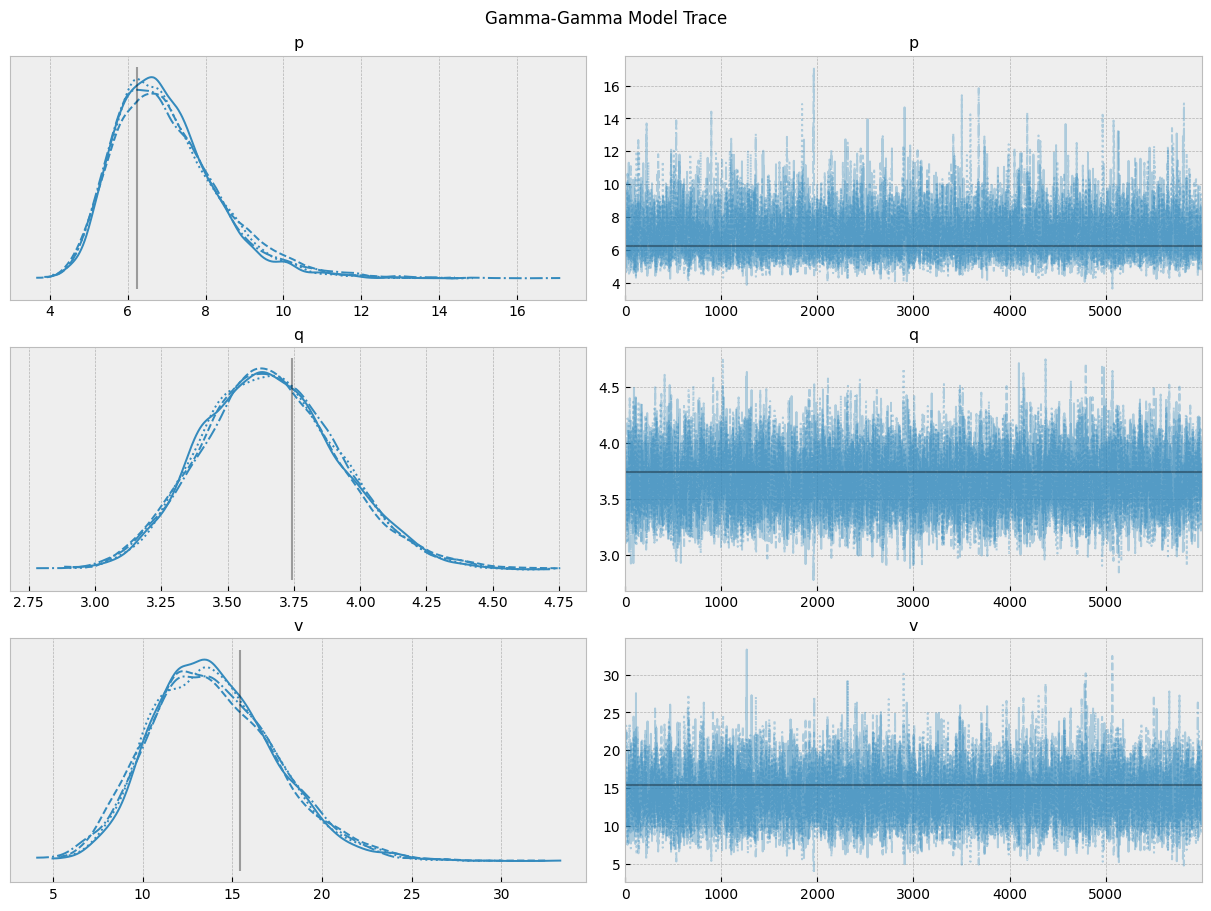

In [9]:
axes = az.plot_trace(
    data=trace,
    lines=[(k, {}, [v]) for k, v in ggf.summary["coef"].items()],
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Gamma-Gamma Model Trace");

In [10]:
az.summary(data=trace, var_names=["p", "q", "v"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,7.007,1.374,4.750,9.556,0.019,0.014,5713.0,6145.0,1.0
q,3.663,0.261,3.174,4.150,0.003,0.002,6752.0,8672.0,1.0
v,13.997,3.480,7.696,20.526,0.047,0.033,5455.0,5846.0,1.0


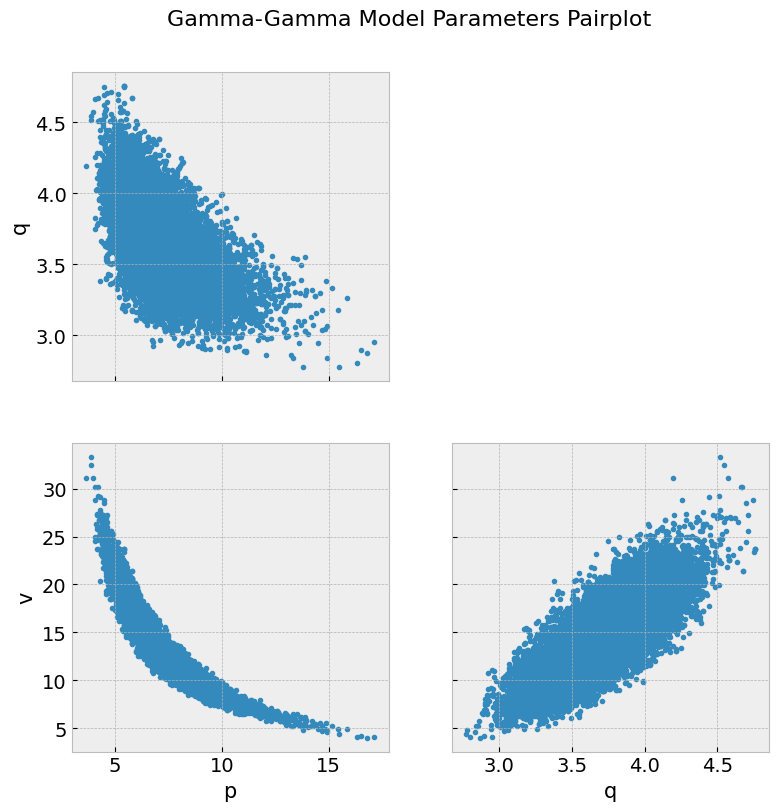

In [11]:
axes = az.plot_pair(data=trace, var_names=["p", "q", "v"], figsize=(9, 9))
fig = axes[0][0].get_figure()
fig.suptitle("Gamma-Gamma Model Parameters Pairplot", y=0.95, fontsize=16);

The expected average profit is a weighted average of individual monetary value and the population mean.

In [12]:
ggf_ceap = ggf.conditional_expected_average_profit(frequency=x, monetary_value=m)

In [14]:
# https://docs.pymc.io/en/stable/pymc-examples/examples/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html
def _sample(array, n_samples):
    """Little utility function, sample n_samples with replacement."""
    idx = np.random.choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]

In [43]:
def conditional_expected_average_profit(trace, x, m, n_samples):
    posterior = trace.posterior.stack(sample=('chain', 'draw'))
    p = _sample(array=posterior["p"], n_samples=n_samples).to_numpy()[..., None]
    q = _sample(array=posterior["q"], n_samples=n_samples).to_numpy()[..., None]
    v = _sample(array=posterior["v"], n_samples=n_samples).to_numpy()[..., None]

    individual_weight = p * x[None, ...] / (p * x[None, ...] + q - 1)

    population_mean = (v * p) / (q - 1)

    return (population_mean * (1 - individual_weight)) + (individual_weight * m)


n_samples = 100
conditional_expected_average_profit(trace, x, m, n_samples)

array([[23.11229406, 16.50224449, 70.66148693, ..., 20.06232319,
        43.27777819, 32.55551939],
       [24.60409452, 18.35261774, 72.13104461, ..., 21.35342899,
        44.51052678, 33.69304982],
       [24.21924207, 18.30414863, 71.10817938, ..., 21.15368321,
        43.82448265, 33.1941617 ],
       ...,
       [22.61310995, 16.18821512, 69.73714183, ..., 19.7041786 ,
        42.6122736 , 32.02604191],
       [24.09398354, 17.40680264, 72.03742673, ..., 20.82862332,
        44.32725551, 33.44109932],
       [21.83748183, 14.27528853, 70.35769271, ..., 18.76472322,
        42.77052188, 31.89046087]])